In [112]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
from datetime import timedelta
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from matplotlib.pyplot import figure
from sodapy import Socrata
import seaborn as sns 

from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score

import pickle
import time
import os

In [113]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [ ]:
#*Conexión a la API Chicago Food Insp*
#client = Socrata("data.cityofchicago.org", None)
#results = client.get("4ijn-s7e5", limit=400000)
#df = pd.DataFrame.from_records(results)
#col_names = df.columns.to_list()
#col_name = []
#for i in range(len(col_names)):
#    col_name.append(col_names[i].replace(" ", "_").lower())
#df.columns =col_name

## Limpieza y preprocesamiento

In [ ]:
def standarize_column_strings(df, columns, excluded_punctuation=".,*¿?¡!"):
    for col in columns:
        df[col] = df[col].str.lower().astype(str).str.replace(" ", "_")
        df[col] = df[col].str.lower().astype(str).str.replace("-", "_")
        df[col] = df[col].str.lower().astype(str).str.replace("á", "a")
        df[col] = df[col].str.lower().astype(str).str.replace("é", "e")
        df[col] = df[col].str.lower().astype(str).str.replace("í", "i")
        df[col] = df[col].str.lower().astype(str).str.replace("ó", "o")
        df[col] = df[col].str.lower().astype(str).str.replace("ú", "u")
        df[col] = df[col].str.lower().astype(str).str.replace("ü", "u")
        df[col] = df[col].str.lower().astype(str).str.replace(r"[^a-zA-Z\d\_]+", "")
        for ch in excluded_punctuation:
            df[col] = df[col].str.replace(ch, "")

In [ ]:
def cleaning(df):
    '''
    Función que convierte las columnas del Data Frame al tipo y forma que se necesita para
    los análisis posteriores
    
    inputs: Data Frame almacenado en el S3 (ingesta.pkl)
    outputs: Data Frame con las variables en formato adecuado (df_clean.pkl)
        
    '''
    #df = pickle.load(open("ingesta.pkl","rb"))
    nrows_prev = df.shape[0]
    ncols_prev = df.shape[1]
    data_null_prev = df.isnull().sum().sum()
    # Variables de texto
    df['violations']= df['violations'].astype('object')
    df['violations_count'] = df.violations.str.count(r'\|')+1
    df['violations_count'] = df.violations_count.fillna(0)
    df['violations_count'] = df['violations_count'].astype('int')
    # Variables categóricas
    df['dba_name']= df['dba_name'].astype('object')
    df['aka_name']= df['aka_name'].astype('object')
    df['facility_type']= df['facility_type'].astype('category')
    df['risk']= df['risk'].astype('category')
    df['address']= df['address'].astype('category')
    df['city']= df['city'].astype('category')
    df['state']= df['state'].astype('category')
    df['inspection_type']= df['inspection_type'].astype('category')
    df['results']= df['results'].astype('category')
    # Variable label_risk
    df['risk'] = df['risk'].replace(["Risk 1 (High)"],3)
    df['risk'] = df['risk'].replace(["Risk 2 (Medium)"],2)
    df['risk'] = df['risk'].replace(["Risk 3 (Low)"],1)
    df['risk'] = df['risk'].replace(["All"],0)
    df['risk'] = pd.to_numeric(df['risk'], errors='coerce')
    df=df.rename(columns = {'risk':'label_risk'})
    df['label_risk'] = df['label_risk'].fillna(3)
    df['label_risk'] = df['label_risk'].astype('int')
    # Variables de fecha
    df['inspection_date'] = pd.to_datetime(df['inspection_date'], infer_datetime_format=True)
    df['inspection_month']=df['inspection_date'].dt.month
    MONTH = 12
    df['sin_mnth'] = np.sin(2*np.pi*df.inspection_month/MONTH)
    df['cos_mnth'] = np.cos(2*np.pi*df.inspection_month/MONTH)
    df['inspection_weekday']=df['inspection_date'].dt.weekday
    WEEKDAY = 7
    df['sin_wkd'] = np.sin(2*np.pi*df.inspection_weekday/WEEKDAY)
    df['cos_wkd'] = np.cos(2*np.pi*df.inspection_weekday/WEEKDAY)
    # Etiqueta
    df['label_results'] = df['results'].apply(lambda x: int(0) if x == 'Fail' else (int(1) if x in ['Pass','Pass w/Conditions'] else int(2)))
    # Imputación de datos
    df.drop(['violations'],axis = 1, inplace = True)
    df.drop(['results'], axis = 1, inplace = True)
    df.drop(df.loc[df['license_'].isnull()].index, inplace=True)
    df.drop(df.loc[df['zip'].isnull()].index, inplace=True)
    df.drop(df.loc[df['label_results'] == 2].index, inplace=True)
    df['aka_name'] = df['aka_name'].fillna(df['dba_name'])
    df['dba_name']= df['dba_name'].astype(str).str.lower()
    df['aka_name']= df['aka_name'].astype(str).str.lower()
    df['facility_type']= df['facility_type'].astype(str).str.lower()
    df['state']= df['state'].astype(str).str.lower()
    df['inspection_type']= df['inspection_type'].astype(str).str.lower()
    df = df[~df['state'].isin(['wi', 'ny', 'in'])]
    col_text = ['dba_name','aka_name']
    df.rename(columns={'license_':'license'}, inplace=True)
    standarize_column_strings(df, col_text)
    df_dict_dummy = pd.DataFrame(df['aka_name'])
    df_dict_dummy['facility_type'] = df['facility_type']
    df_dict_dummy.drop(df_dict_dummy.loc[df_dict_dummy['facility_type'].isnull()].index, inplace=True)
    group = df_dict_dummy.groupby('aka_name')
    df_dict_dummy2 = group.apply(lambda x: x['facility_type'].unique())
    df_dict_dummy3 = df_dict_dummy2.to_frame()
    df_dict_dummy3.reset_index(level = 'aka_name', inplace = True)
    df_dict_dummy3 = df_dict_dummy3.rename(columns = {0:'facility_type'})
    df_dict_dummy3['facility_type'] = df_dict_dummy3['facility_type'].apply(lambda x: str(x[0]))
    df2 = pd.merge(df,df_dict_dummy3, how = 'left', on = 'aka_name')
    df2['facility_type_x'] = df2['facility_type_x'].fillna(df2['facility_type_y'])
    df2['facility_type_x'] = df2['facility_type_x'].fillna('restaurant')
    df2=df2.rename(columns = {'facility_type_x':'facility_type'})
    df2.drop(['inspection_id','dba_name','address','city','state','latitude','longitude','location','facility_type_y','inspection_weekday','inspection_month'],axis = 1, inplace = True)
    df2 = df2.dropna() #---------------------------------------->adición
    nrows_after = df2.shape[0]
    ncols_after = df2.shape[1]
    return df2, nrows_prev, ncols_prev, nrows_after, ncols_after, data_null_prev

## Feature Engineering

In [ ]:
def zips(x,lev,dic):
    if x in lev.zip.to_list():
        return dic[x]
    else:
        return 'other'

In [ ]:
def feat_eng2(df_fe):
    '''
    Función que realiza la selección de los features que serán utilizdos para la clasificación
    
    inputs: Data Frame limpio (df_clean.pkl)
    outputs: Data Frame con la matriz de diseño para el modelo (df_clean.pkl)
        
    '''
    # Transformación de variables facility_type y zip
    tipo = pd.DataFrame(df_fe.facility_type.value_counts())
    tipo['name'] = tipo.index
    tipo.index = range(len(tipo.name))
    grupo1 = tipo.iloc[0:4,1].tolist()
    grupo2 = tipo.iloc[[5,6,7,11],1].tolist()
    df_fe['class'] = df_fe['facility_type'].apply(lambda x: x if x in grupo1 else ('daycare' if x in grupo2 else 'other'))
    lev = pd.read_csv('levels.csv')
    lev['zip'] = lev['zip'].astype(str)
    lev.index = lev.zip
    dic = lev.level.to_dict()
    df_fe['level'] = df_fe['zip'].apply(lambda x: zips(x,lev,dic))
    # Transformación a OHE
    df_fe = df_fe.sort_values(by='inspection_date', ascending=True)
    df_input = pd.DataFrame(df_fe[['label_risk','label_results','level','class']])
    data_input_ohe = pd.get_dummies(df_input)
    etiqueta = data_input_ohe.label_results
    data_input_ohe= data_input_ohe.drop('label_results', axis = 1)
    variables_lista = list(data_input_ohe.columns)
    # Grid Search
    np.random.seed(20201124)
    # ocuparemos un RF
    classifier = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=1234)
    # separando en train, test
    #X_train, X_test, y_train, y_test = train_test_split(data_input_ohe, etiqueta, test_size=0.3)

    # definicion de los hiperparametros que queremos probar
    hyper_param_grid = {'n_estimators': [300, 400], #'min_samples_leaf': [3,5,7],
                        'max_depth': [7, 10],
                        #'min_samples_split': [3],
                        'max_features': [5, 10],
                        'criterion': ['gini']}
    # usamos TimeSeriesSplit para dividir respetando el orden cronológico
    tscv = TimeSeriesSplit(n_splits=6)
    # This was the trickiest part as a newbie. Straight from the docs
    # If you only have experience with CV splits this way
    # of making the splits might seem foreign. Fret not.
    for train_index, test_index in tscv.split(data_input_ohe):
        X_train, X_test = data_input_ohe.iloc[train_index, :], data_input_ohe.iloc[test_index,:]
        y_train, y_test = etiqueta.iloc[train_index], etiqueta.iloc[test_index]
    # ocupemos grid search
    gs = GridSearchCV(classifier, 
                           hyper_param_grid, 
                           scoring = 'precision', return_train_score=True,
                           cv = tscv)
    start_time = time.time()
    gs.fit(X_train, y_train)
    best_rf = gs.best_estimator_
    best_score = gs.best_estimator_.oob_score_
    feature_importance = pd.DataFrame({'importance':\
                                       best_rf.feature_importances_,\
                                       'feature': variables_lista})
    feature_importance=feature_importance.sort_values(by="importance", ascending=False)
    #fi_out = feature_importance.head(10)
    time_exec = time.time() - start_time
    nrows_ohe = data_input_ohe.shape[0]
    ncols_ohe = data_input_ohe.shape[1]
    #print("Tiempo en ejecutar: ", time.time() - start_time)
    return df_input, nrows_ohe, ncols_ohe, float(best_score), time_exec, str(best_rf)

In [ ]:
def feat_eng(df_fe):
    '''
    Función que realiza la selección de los features que serán utilizdos para la clasificación
    
    inputs: Data Frame limpio (df_clean.pkl)
    outputs: Data Frame con la matriz de diseño para el modelo (df_clean.pkl)
        
    '''
    
    # Transformación de variables facility_type y zip
    tipo = pd.DataFrame(df_fe.facility_type.value_counts())
    tipo['name'] = tipo.index
    tipo.index = range(len(tipo.name))
    grupo1 = tipo.iloc[0:4,1].tolist()
    grupo2 = tipo.iloc[[5,6,7,11],1].tolist()
    df_fe['class'] = df_fe['facility_type'].apply(lambda x: x if x in grupo1 else ('daycare' if x in grupo2 else 'other'))
    lev = pd.read_csv('zip_catalog.csv')
    lev['zip'] = lev['zip'].astype(str)
    lev.index = lev.zip
    dic = lev.level.to_dict()
    df_fe['level'] = df_fe['zip'].apply(lambda x: zips(x,lev,dic))
    
    
    # Transformación a OHE
    df_fe = df_fe.sort_values(by='inspection_date', ascending=True)
    df_input = pd.DataFrame(df_fe[['label_risk','label_results','level','class']])
    data_input_ohe = pd.get_dummies(df_input)
    etiqueta = data_input_ohe.label_results
    data_input_ohe= data_input_ohe.drop('label_results', axis = 1)
    variables_lista = list(data_input_ohe.columns)
    # Grid Search
    np.random.seed(20201124)
    # ocuparemos un RF
    classifier = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=1234)
    # separando en train, test
    #X_train, X_test, y_train, y_test = train_test_split(data_input_ohe, etiqueta, test_size=0.3)

    # definicion de los hiperparametros que queremos probar
    hyper_param_grid = {'n_estimators': [300, 400], #'min_samples_leaf': [3,5,7],
                        'max_depth': [7, 10],
                        #'min_samples_split': [3],
                        'max_features': [3, 5, 6],
                        'criterion': ['gini']}
    # usamos TimeSeriesSplit para dividir respetando el orden cronológico
    tscv = TimeSeriesSplit(n_splits=3)
    # This was the trickiest part as a newbie. Straight from the docs
    # If you only have experience with CV splits this way
    # of making the splits might seem foreign. Fret not.
    for train_index, test_index in tscv.split(data_input_ohe):
        X_train, X_test = data_input_ohe.iloc[train_index, :], data_input_ohe.iloc[test_index,:]
        y_train, y_test = etiqueta.iloc[train_index], etiqueta.iloc[test_index]
    # ocupemos grid search
    gs = GridSearchCV(classifier, 
                           hyper_param_grid, 
                           scoring = 'precision', return_train_score=True,
                           cv = tscv)
    start_time = time.time()
    gs.fit(X_train, y_train)
    best_rf = gs.best_estimator_
    best_score = gs.best_estimator_.oob_score_
    feature_importance = pd.DataFrame({'importance':\
                                       best_rf.feature_importances_,\
                                       'feature': variables_lista})
    feature_importance=feature_importance.sort_values(by="importance", ascending=False)
    
    #fi_out = feature_importance.head(10)
    
    time_exec = time.time() - start_time
    nrows_ohe = data_input_ohe.shape[0]
    ncols_ohe = data_input_ohe.shape[1]
    
    df_input = pd.DataFrame(df_fe[['aka_name','license','label_risk','label_results','level','class']])
    
    return df_input, nrows_ohe, ncols_ohe, float(best_score), time_exec, str(best_rf)

## Entrenamiento

In [106]:
def train(df_fe):
    # Aplicamos OneHot Encoding
    df_fe.drop(['aka_name','license'], axis = 1,inplace = True) #Hubo cambio
    data_input_ohe = pd.get_dummies(df_fe)
    etiqueta = data_input_ohe.label_results
    data_input_ohe = data_input_ohe.drop(['label_results'], axis = 1) #Hubo cambio
    variables_lista = list(data_input_ohe.columns)
    # Hacemos TimeSeriesSplit para obtener las matrices de entrenamiento y prueba
    tscv = TimeSeriesSplit(n_splits=3)
    for train_index, test_index in tscv.split(data_input_ohe):
        X_train, X_test = data_input_ohe.iloc[train_index, :], data_input_ohe.iloc[test_index,:]
        y_train, y_test = etiqueta.iloc[train_index], etiqueta.iloc[test_index]
    # Metadata de las matrices para el modelo
    nrows_train = X_train.shape[0]
    nrows_test = X_test.shape[0]
    meta_train = pd.DataFrame({'nrows_train' : nrows_train,
                           'nrows_test' : nrows_test}, index = [0])
    # Hacemos un solo DF para los Datasets de Entrenamiento y Prueba y con la etiqueta
    X_train_1 = X_train.assign(Set = 'entrenamiento')
    X_train_1 = X_train_1.assign(etiqueta = y_train)
    X_test_1 = X_test.assign(Set = 'prueba')
    X_test_1 = X_test_1.assign(etiqueta = y_test)
    df_train_test = pd.concat([X_train_1, X_test_1], axis = 0)
    return df_train_test, nrows_train, nrows_test

## Selección de Modelo

In [107]:
def model(df_train_test):
    # Funciones para regresar el DataFrame con las etiquetas y los sets de entrenamiento y 
    # y prueba a los cuatro DF X_train, Y_train, X_test y Y_test
    X_train = df_train_test[df_train_test.Set == 'entrenamiento']
    y_train = X_train.etiqueta
    X_train = X_train.iloc[:,0:df_train_test.shape[1]-2]
    X_test = df_train_test[df_train_test.Set == 'prueba']
    #y_test = X_test.etiqueta
    X_test = X_test.iloc[:,0:df_train_test.shape[1]-2]
    # Algoritmos a evaluar: DecisionTree y RandomForest
    algorithms_dict = {'tree': 'tree_grid_search'}
    algorithms = ['tree']
    # Hiperparámetros a evaluar en cada algoritmo:
    grid_search_dict = {'tree_grid_search': {'max_depth': [5,10,15], 
                                         'min_samples_leaf': [3,5,7]}}
    # Configuraciones generales de cada algoritmo a evaluar:
    estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111)}
    best_estimators = []
    # Magic loop
    tscv = TimeSeriesSplit(n_splits=3)
    start_time = time.time()
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]
        gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=tscv, n_jobs=-1)
        #train
        gs.fit(X_train, y_train)
        #best estimator
        best_estimators.append(gs)
    
    # MEtadata:
    # Mejor modelo de árbol
    best_tree = best_estimators[0].best_estimator_
    # Tiempo de ejecución
    t_exec = time.time() - start_time
    # Información de los modelos considerados en la selección
    r = pd.DataFrame(best_estimators[0].cv_results_)
    r = r.sort_values("rank_test_score")
    lista = r.params.astype(str)
    test_mod = "|".join(lista)
    lista_2 = r.mean_test_score.astype(str)
    mean_scores = "|".join(lista_2)
    lista_3 = r.rank_test_score.astype(str)
    rank_model = "|".join(lista_3)
    # Persistir mejor modelo en .pkl
    obj_model = best_tree.fit(X_train, y_train)
#    pickle.dump(best_tree, open("best_model.pkl", 'wb'))
#    model_pkl = pickle.load(open("best_model.pkl","rb"))
    return obj_model, str(best_tree), t_exec, test_mod, mean_scores, rank_model

# Sesgo e Inequidad

In [108]:
def bias_fair(modelo,df_train_test,df_fe):
    # Separamos los sets de entrenamiento y prueba
    # Entrenamiento
    X_train = df_train_test[df_train_test.Set == 'entrenamiento']
    y_train = X_train.etiqueta
    X_train = X_train.iloc[:,0:df_train_test.shape[1]-2]
    # Prueba
    X_test = df_train_test[df_train_test.Set == 'prueba']
    y_test = X_test.etiqueta
    X_test = X_test.iloc[:,0:df_train_test.shape[1]-2]
    predicted_scores = modelo.predict_proba(X_test)
    
    # Se conforma el DataFrame que necesita Aequitas para el sesgo e inequidad de la variable facility_type (class)
    df_dummy = pd.DataFrame()
    df_dummy['scores'] = pd.Series(predicted_scores[:,1])
    df_dummy['predic'] = np.where(df_dummy['scores'] < 0.7,0,1)
    df_aeq = pd.DataFrame()
    df_aeq['real'] = y_test
    df_aeq['prediccion'] = df_dummy.predic
    df_aeq['faciliy_type'] = df_fe['class'].tail(len(df_dummy.predic))
    # Asignamos nuevos índices y los nombres de las columnas para que los reconozca la función
    df_aeq = df_aeq.reset_index(drop=True)
    df_aeq.columns = ['label_value','score','class']
    # Se obtienen las métricas
    g = Group()
    xtab, attrbs = g.get_crosstabs(df_aeq)
    absolute_metrics = g.list_absolute_metrics(xtab)
    metrics1 = xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(2)
    
    # Se conforma el DataFrame que necesita Aequitas para el sesgo e inequidad de la variable zip (level)
    df_aeq2 = pd.DataFrame()
    df_aeq2['real'] = y_test
    df_aeq2['prediccion'] = df_dummy.predic
    df_aeq2['zip'] = df_fe['level'].tail(len(df_dummy.predic))
    # Asignamos nuevos índices y los nombres de las columnas para que los reconozca la función
    df_aeq2 = df_aeq2.reset_index(drop=True)
    df_aeq2.columns = ['label_value','score','level']
    # Se obtienen las métricas
    g2 = Group()
    xtab2, attrbs2 = g2.get_crosstabs(df_aeq2)
    absolute_metrics2 = g2.list_absolute_metrics(xtab2)
    metrics2 = xtab2[['attribute_name', 'attribute_value']+[col for col in xtab2.columns if col in absolute_metrics2]].round(2)
    
    df_labels = pd.DataFrame()
    df_labels['scores'] = pd.Series(predicted_scores[:,1])
    df_labels['predicted'] = np.where(df_dummy['scores'] < 0.7,0,1)
    df_labels['label'] = y_test
    
    metrics = pd.concat([metrics1,metrics2]).reset_index(drop = True)
        
    # Metadata
    n_groups = len(metrics1.attribute_value) + len(metrics2.attribute_value)
    n_attribute = metrics.attribute_name.nunique()
    prop_pos_pred = df_labels.predicted.sum()/len(df_labels.predicted)
    prop_pos_real = df_labels.label.sum()/len(df_labels.label)
        
    return df_labels, metrics, n_groups, n_attribute, prop_pos_pred, prop_pos_real

# Predicción

In [ ]:
def predict(df_fe, model):
    var = df_fe[['aka_name', 'license']]
    df_fe.drop(['date', 'aka_name', 'license'], axis=1, inplace=True)
    data_input_ohe = pd.get_dummies(df_fe)
    etiqueta = data_input_ohe.label_results
    data_input_ohe= data_input_ohe.drop('label_results', axis = 1)
    base = pd.DataFrame({'label_risk':0,'level_downtown':0,'level_high':0,'level_low-mid':0,'level_other':0,
                    "class_children's services facility":0,'class_daycare':0,'class_grocery store':0,
                    'class_other':0,'class_restaurant':0,'class_school':0}, index = [0])
    b  = list(base.columns)
    orig = data_input_ohe.columns.tolist()
    miss_col = []
    cont = 0

    for item in b:
        if item not in orig:
            miss_col.append(cont)
            cont = cont + 1
        else:
            cont = cont + 1
    
    for index in miss_col:
        data_input_ohe.insert(index,base.columns[index],0)
        
    predicted_scores = pd.DataFrame(model.predict_proba(data_input_ohe))
    predicted_scores['predic'] = np.where(predicted_scores[1] < 0.7,0,1)
    salida = var.loc[data_input_ohe.index,['aka_name','license']].reset_index()
    salida['score'] = predicted_scores.iloc[:,1]
    salida['prediction'] = predicted_scores.iloc[:,2]
    return salida

### Data Frame original

In [ ]:
df_raw = pickle.load(open("raw.pkl","rb"))
df_raw = pd.DataFrame(df_raw)
#df_raw.info()

In [ ]:
df2, nrows_prev, ncols_prev, nrows_after, ncols_after, data_null_prev = cleaning(df_raw)

In [ ]:
df2.info()

In [ ]:
df_input, nrows_ohe, ncols_ohe, best_score, time_exec, best_rf = feat_eng(df2)

In [ ]:
df_input.info()

In [ ]:
var = df_input[['aka_name','license']]
var

In [ ]:
pickle.dump(df_input,open("df_fe.pkl","wb"))

In [ ]:
time_exec

In [ ]:
df_input.info()

In [ ]:
df_input.label_risk.value_counts()

In [ ]:
df_input.label_results.value_counts()

In [ ]:
df_train_test, nrows_train, nrows_test = train(df_input)

In [ ]:
df_train_test.info()

In [ ]:
obj_model, best_tree, t_exec, test_mod, mean_scores, rank_model = model(df_train_test)

In [ ]:
obj_model

In [ ]:
df_labels, metrics, n_groups, n_attribute, prop_pos_pred, prop_pos_real = bias_fair(obj_model,df_train_test,df_input)

In [ ]:
metrics.precision.mean()

In [ ]:
pickle.dump(df2,open("limpieza.pkl","wb"))             # DF limpio
pickle.dump(df_input,open("feat_eng.pkl","wb"))        # DF con el Feature Engineering
pickle.dump(df_train_test,open("train_test.pkl","wb")) # Entrenamiento y Prueba
pickle.dump(obj_model,open("obj_model.pkl","wb"))      # Selección del Modelo
pickle.dump(metrics,open("metrics.pkl","wb"))          # Métricas de desempeño

In [ ]:
df_raw = pickle.load(open("df_raw.pkl","rb"))
df_clean = pickle.load(open("df_clean.pkl","rb"))
df_fe = pickle.load(open("df_fe.pkl","rb"))
m = pickle.load(open("best_model.pkl","rb"))
df_trn_tst = pickle.load(open("df_trn_tst.pkl","rb"))

**Transformación a OHE**

In [ ]:
# Pickle con la base de datos original
#pickle.dump(df,open("df_raw.pkl","wb"))

In [ ]:
# Limpia la Base de Datos
#df_raw = pickle.load(open("df_raw.pkl","rb"))
#df_clean, nrows_prev, ncols_prev, nrows_after, ncols_after, data_null_prev = cleaning(df_raw)

**Extracción de datos del último día de 2020 hacia atrás**

In [ ]:
df_clean = pickle.load(open("df_clean.pkl","rb"))

In [ ]:
var = df_clean.loc[df_clean.inspection_date > pd.to_datetime('2020-12-31'), :].index
df_clean = df_clean.drop(var,axis=0).reset_index(drop = True)

In [ ]:
#meta_clean = pd.DataFrame({'nrows_prev' : nrows_prev,
#                        'ncols_prev' : ncols_prev,
#                        'nrows_after' : nrows_after,
#                        'ncols_after' : ncols_after,
#                        'data_null_prev' : data_null_prev}, index = [0])
#meta_clean

In [ ]:
# Pickles con la base de datos limpia y su metadata
pickle.dump(df_clean,open("df_clean.pkl","wb"))
#pickle.dump(meta_clean,open("meta_clean.pkl","wb"))

In [ ]:
df_fe, nrows_ohe, ncols_ohe, best_score, time_exec, best_rf = feat_eng(df_clean)

In [ ]:
time_exec

In [ ]:
df_clean.shape

In [ ]:
df_fe.head()

In [ ]:
best_score

In [ ]:
meta_fe = pd.DataFrame({'nrows_ohe' : nrows_ohe,
                        'ncols_ohe' : ncols_ohe,
                        'best_score' : best_score,
                        'time_exec' : time_exec,
                        'best_rf' : best_rf}, index = [0])
meta_fe                        

In [ ]:
# Pickles con Feature Engineering y su metadata
pickle.dump(df_fe,open("df_fe.pkl","wb"))
pickle.dump(meta_fe,open("meta_fe.pkl","wb"))

In [ ]:
import pickle
df_fe = pickle.load(open("df_fe.pkl","rb"))

In [ ]:
# Aplicamos OneHot Encoding
data_input_ohe = pd.get_dummies(df_fe)
etiqueta = data_input_ohe.label_results
data_input_ohe= data_input_ohe.drop('label_results', axis = 1)
variables_lista = list(data_input_ohe.columns)

In [ ]:
# Hacemos TimeSeriesSplit para obtener las matrices de entrenamiento y prueba
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(data_input_ohe):
    X_train, X_test = data_input_ohe.iloc[train_index, :], data_input_ohe.iloc[test_index,:]
    y_train, y_test = etiqueta.iloc[train_index], etiqueta.iloc[test_index]

In [ ]:
# Metadata de las matrices para el modelo
nrows_train = X_train.shape[0]
nrows_test = X_test.shape[0]
meta_train = pd.DataFrame({'nrows_train' : nrows_train,
                           'nrows_test' : nrows_test}, index = [0])
meta_train

In [ ]:
# Hacemos un solo DF para los Datasets de Entrenamiento y Prueba y con la etiqueta
X_train_1 = X_train.assign(Set = 'entrenamiento')
X_train_1 = X_train_1.assign(etiqueta = y_train)
X_test_1 = X_test.assign(Set = 'prueba')
X_test_1 = X_test_1.assign(etiqueta = y_test)
df_train_test = pd.concat([X_train_1, X_test_1], axis = 0)

df_train_test.shape

In [ ]:
max(df_train_test.etiqueta) > 0

In [ ]:
pickle.dump(df_train_test,open("df_trn_tst.pkl","wb"))

In [ ]:
# Funciones para regresar el DataFrame con las etiquetas y los sets de entrenamiento y 
# y prueba a los cuatro DF Xtrain, Ytrain, Xtst y Ytest
X_train_2 = df_train_test[df_train_test.Set == 'entrenamiento']
y_train_2 = X_train_2.etiqueta
X_train_2 = X_train_2.iloc[:,0:df_train_test.shape[1]-2]


X_test_2 = df_train_test[df_train_test.Set == 'prueba']
y_test_2 = X_test_2.etiqueta
X_test_2 = X_test_2.iloc[:,0:df_train_test.shape[1]-2]

In [ ]:
# Algoritmos a evaluar: DecisionTree y RandomForest
algorithms_dict = {'tree': 'tree_grid_search'}
algorithms = ['tree']
# Hiperparámetros a evaluar en cada algoritmo:
grid_search_dict = {'tree_grid_search': {'max_depth': [5,10,15], 
                                         'min_samples_leaf': [3,5,7]}}

# Configuraciones generales de cada algoritmo a evaluar:
estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111)}
best_estimators = []

In [ ]:
start_time = time.time()
for algorithm in algorithms:
    estimator = estimators_dict[algorithm]
    grid_search_to_look = algorithms_dict[algorithm]
    grid_params = grid_search_dict[grid_search_to_look]
    gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=tscv, n_jobs=-1)
    start_time = time.time()
    #train
    gs.fit(X_train, y_train)
    #best estimator
    best_estimators.append(gs)
time_exec = time.time() - start_time

In [ ]:
best_tree = best_estimators[0].best_estimator_
best_tree

In [ ]:
r = pd.DataFrame(best_estimators[0].cv_results_)
r = r.sort_values("rank_test_score")
r.head(2)

In [ ]:
lista = r.params.astype(str)
test_mod = "|".join(lista)
lista_2 = r.mean_test_score.astype(str)
mean_scores = "|".join(lista_2)
lista_3 = r.rank_test_score.astype(str)
rank_model = "|".join(lista_3)

In [ ]:
test_mod

In [ ]:
mean_scores

In [ ]:
rank_model

In [ ]:
tabla = pd.DataFrame({"best":best_tree,"modelos":test_mod,"mean_scores":mean_scores,
                      "rank_model":rank_model},index=[0])
tabla

In [ ]:
model = best_tree

In [ ]:
m = model.fit(X_train, y_train)
pickle.dump(m, open("best_model.pkl", 'wb'))

In [ ]:
m = pickle.load(open("best_model.pkl","rb"))

In [ ]:
type(m)

In [ ]:
resultados = m.predict(X_test)

In [ ]:
res = pd.DataFrame(resultados)
res=res.rename(columns = {0:'label'})
res.label.value_counts()

In [ ]:
res_2 = pd.DataFrame(y_test)
res_2.label_results.value_counts()

# Accuracy

In [ ]:
accuracy_score(y_test, resultados)

In [ ]:
df_labels, metrics, n_groups, n_attribute, prop_pos_pred, prop_pos_real = bias_fair(m,df_trn_tst,df_fe)

In [ ]:
metrics

In [ ]:
df_labels

In [ ]:
prop_pos_pred = df_labels.predicted.sum()/len(df_labels.predicted)
prop_pos_pred

In [ ]:
prop_pos_real = df_labels.label.sum()/len(df_labels.label)
prop_pos_real

In [ ]:
# Entrenamiento
X_train = df_trn_tst[df_trn_tst.Set == 'entrenamiento']
y_train = X_train.etiqueta
X_train = X_train.iloc[:,0:df_trn_tst.shape[1]-2]
# Prueba
X_test = df_trn_tst[df_trn_tst.Set == 'prueba']
y_test = X_test.etiqueta
X_test = X_test.iloc[:,0:df_trn_tst.shape[1]-2]
predicted_scores = m.predict_proba(X_test)

In [ ]:
df_dummy = pd.DataFrame()
df_dummy['scores'] = pd.Series(predicted_scores[:,1])
df_dummy['predic'] = np.where(df_dummy['scores'] < 0.7,0,1)
df_dummy.head(3)

In [ ]:
df_aeq2 = pd.DataFrame()
df_aeq2['real'] = y_test
df_aeq2['prediccion'] = df_dummy.predic
df_aeq2['zip'] = df_fe['level'].tail(len(df_dummy.predic))

In [ ]:
df_aeq2 = df_aeq2.reset_index(drop=True)
df_aeq2.columns = ['label_value','score','level']

In [ ]:
g2 = Group()
xtab2, attrbs2 = g2.get_crosstabs(df_aeq2)

In [ ]:
absolute_metrics2 = g2.list_absolute_metrics(xtab2)

In [ ]:
xtab2[[col for col in xtab2.columns if col not in absolute_metrics2]]

In [ ]:
metrics2 = xtab2[['attribute_name', 'attribute_value']+[col for col in xtab2.columns if col in absolute_metrics2]].round(2)
metrics2

In [ ]:
con = pd.concat([metrics2,metrics2]).reset_index(drop = True)
con.attribute_name.nunique()

In [ ]:
aeq2 = Plot()

In [ ]:
for_2 = aeq2.plot_group_metric(xtab2, 'for')

In [ ]:
recall2 = aeq2.plot_group_metric(xtab2, 'tpr')

**¿Cuáles son los atributos protegidos?**

Se hicieron dos ejercicios. El primero consistió en tomar como atributo protegido el tipo de establecimiento (facility_type). Para generar esta variable, dado que existen 500 tipos de establecimiento, se clasificaron los grupos de mayor representación en la base de datos, resultando 4 los de mayor aparición ("restaurant","school", "grocery store", "children's services facility"), después se agruparon tres categorías que se refieren a "day care" y el resto se clasificó como "other", esto por la heterogeneidad de establecimientos que ya no entraban en las categorías previas.

El segundo consistió en tomar como atributo protegido el código postal (zip), para ello se creó una tabla de códigos postales clasificados por tipo de ingreso: "High", "Low-mid" y "Down town" (ver referencias) y, debido a que hay algunos códigos postales que se encuentran fuera del área de Chicago y no contamos con su clasificación de ingreso, se dejó en una categoría denominada "other".

**¿Qué grupos de referencia tiene cada atributo protegido?, explica el por qué**

Para el atributo "facility_type", el grupo de referencia es la categoría de "restaurante", porque es la que tiene mayor representación en la base de datos y el objetivo sería que no haya sesgo en las predicciones con etiqueta negativa hacia este tipo de establecimiento.

Para el atributo "zip", el grupo de referencia es la categoría de "low-mid" pues el objetivo sería que no haya sesgo en las predicciones con etiqueta negativa hacia este tipo de zonas (con menor ingreso), que pudieran generar mayor disparidad respecto a las demás zonas ("High" y "Downtown") tomando en cuenta que la cancelación de licencias de restaurantes puede afectar sensiblemente la economía o el desarrollo de alguna zona.

**¿Tu modelo es punitivo o asistivo? explica por qué**

De acuerdo con la pregunta análitica que se desea responder con el modelo predictivo (¿El establecimiento pasará o no la inspección?) y tomando en cuenta que el producto de datos estará orientado para que el uso sea por parte de los establecimientos y no del gobierno de Chicago para enviar inspecciones, consideramos que el modelo es asistivo ya que permitirá a los dueños de los establecimientos realizar consultas sobre si su establecimiento pasaría o no una inspección, permitiéndoles prevenir posibles multas o cancelaciones de licencia por incumplimiento.

**¿Qué métricas cuantificarás y ocuparás en sesgo e inequidad? explica por qué**

- ***Equal Parity***: Esta métrica no es tan útil para nuestro objetivo porque nos interesa mejorar ninguno de los grupos, solo nos interesa orientar a los usuarios sobre si su establecimiento está o no en riesgo de pasar una posible inspección.

- ***False Positive Parity***: 


- ***FNR Parity***: la interpretamos de la siguiente manera; dado que se recibe una alerta falsa, cuál es la probabilidad de que hayamos enviado una ambulancia dado la delegación a la que pertenece la llamada. Seleccionamos la métrica porque queremos verificar si alguna delegación tiene ventaja sobre otra.

In [ ]:
# Algoritmos a evaluar: DecisionTree y RandomForest
algorithms_dict = {'random_forest': 'rf_grid_search'}
algorithms = ['random_forest']
# Hiperparámetros a evaluar en cada algoritmo:
grid_search_dict = {'rf_grid_search': {'n_estimators': [500],  
                                      'max_depth': [5,10], 
                                      'min_samples_leaf': [10]}}

# Configuraciones generales de cada algoritmo a evaluar:
estimators_dict = {'random_forest': RandomForestClassifier(oob_score=True, random_state=2222)}
best_estimators = []

In [ ]:
start_time = time.time()
for algorithm in algorithms:
    estimator = estimators_dict[algorithm]
    grid_search_to_look = algorithms_dict[algorithm]
    grid_params = grid_search_dict[grid_search_to_look]
    gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=tscv, n_jobs=-1)
    start_time = time.time()
    #train
    gs.fit(X_train, y_train)
    #best estimator
    best_estimators.append(gs)
time_exec = time.time() - start_time

In [ ]:
best_rf = best_estimators[0].best_estimator_
best_rf

In [ ]:
model_rf = best_rf
m_rf = model_rf.fit(X_train, y_train)
pickle.dump(m, open("best_model_rf.pkl", 'wb'))

In [ ]:
resultados_rf = best_rf.predict(X_test)

In [ ]:
res_rf = pd.DataFrame(resultados_rf)
res_rf = res_rf.rename(columns = {0:'label'})
res_rf.label.value_counts()

In [ ]:
cons = pickle.load(open("consecutiva.pkl","rb"))
type(cons)

## Predicciones

In [ ]:
df_fe = pickle.load(open("df_fe.pkl","rb"))
df_fe = pd.DataFrame(df_fe)

In [ ]:
df_fe['date'] = 'a'

In [ ]:
model = pickle.load(open("obj_model.pkl","rb"))
model

In [ ]:
sal = predict(fe, model)
sal

In [ ]:
fe_pred = fe.sample(n=200)
fe_pred.head(4)

In [ ]:
var = fe_pred[['aka_name', 'license']]
fe_pred.drop(['date', 'aka_name', 'license'], axis=1, inplace=True)
data_input_ohe = pd.get_dummies(fe_pred)
etiqueta = data_input_ohe.label_results
data_input_ohe= data_input_ohe.drop('label_results', axis = 1)
variables_lista = list(data_input_ohe.columns)

In [ ]:
base = pd.DataFrame({'label_risk':0,'level_downtown':0,'level_high':0,'level_low-mid':0,'level_other':0,
                    "class_children's services facility":0,'class_daycare':0,'class_grocery store':0,
                    'class_other':0,'class_restaurant':0,'class_school':0}, index = [0])

In [ ]:
b  = list(base.columns)
orig = data_input_ohe.columns.tolist()

In [ ]:
miss_col = []
cont = 0

for item in b:
    if item not in orig:
        miss_col.append(cont)
        cont = cont + 1
    else:
        cont = cont + 1
    

In [ ]:
for index in miss_col:
    data_input_ohe.insert(index,base.columns[index],0)

In [ ]:
predicted_scores = pd.DataFrame(model.predict_proba(data_input_ohe))

In [ ]:
predicted_scores['predic'] = np.where(predicted_scores[1] < 0.7,0,1)

In [ ]:
predicted_scores

In [ ]:
var.head(3)

In [ ]:
data_input_ohe.head(3)

In [118]:
salida = var.loc[data_input_ohe.index,['aka_name','license']].reset_index()
salida['score'] = predicted_scores.iloc[:,1]
salida['prediction'] = predicted_scores.iloc[:,2]
salida

,index,aka_name,license,score,prediction
0,81738,ameritalia,2326523,0.798573,1
1,41115,chicago_pizzeria,2114550,0.746999,1
2,44677,high_school_prep_center,3619432,0.802469,1
3,140909,dominicks,2042084,0.769123,1
4,132432,au_bon_pain,1095163,0.798573,1
...,...,...,...,...,...
195,94692,mikes_neighborhood_grocery,2153437,0.740741,1
196,69368,friedman_place,1647252,0.781596,1
197,106571,taza,1647924,0.798573,1
198,13899,subway,2093683,0.798573,1


In [ ]:
df_predic = pickle.dump(salida, open("df_predic.pkl", 'wb'))

In [ ]:
plt.hist(salida.score,bins=20)

In [ ]:
df_raw.head(3)

In [ ]:
salida.drop(['aka_name','license'], axis = 1, inplace = True)

In [ ]:
salida

In [105]:
df_fe = pickle.load(open("df_fe.pkl","rb"))
df_fe = pd.DataFrame(df_fe)

In [109]:
df_train_test, nrows_train, nrows_test = train(df_fe)

In [110]:
obj_model, best_tree, t_exec, test_mod, mean_scores, rank_modeldef = model(df_train_test)

In [114]:
df_labels, metrics, n_groups, n_attribute, prop_pos_pred, prop_pos_real = bias_fair(obj_model,df_train_test,df_fe)

In [115]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38581 entries, 0 to 38580
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   scores     38581 non-null  float64
 1   predicted  38581 non-null  int64  
 2   label      36620 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 904.4 KB


(array([3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0000e+00, 0.0000e+00, 7.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.2570e+03, 6.2200e+02, 1.7030e+03, 1.8231e+04,
        6.6480e+03, 8.8610e+03, 1.1470e+03, 8.7000e+01, 1.1000e+01]),
 array([0.2     , 0.236875, 0.27375 , 0.310625, 0.3475  , 0.384375,
        0.42125 , 0.458125, 0.495   , 0.531875, 0.56875 , 0.605625,
        0.6425  , 0.679375, 0.71625 , 0.753125, 0.79    , 0.826875,
        0.86375 , 0.900625, 0.9375  ]),
 <a list of 20 Patch objects>)

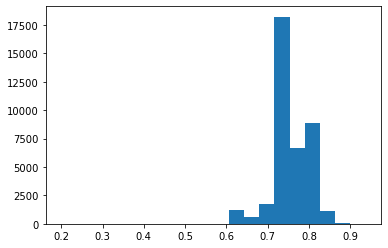

In [116]:
plt.hist(df_labels.scores,bins=20)

In [117]:
pickle.dump(df_labels, open("df_labels.pkl", 'wb'))